# Sprint5課題 機械学習スクラッチSVM

In [1]:
"""
irisデータを読み込むコード
"""

from sklearn.datasets import load_iris
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = load_iris()
df_X = DataFrame(data=data.data, columns=pd.Index(["sepal_length", "sepal_width", "petal_length", "petal_width"]))
df_y = DataFrame(data=data.target, columns=pd.Index(["Target"]))
df_X =df_X[["sepal_length", "petal_length"]]
df_train= df_X.join(df_y).query("Target == [1, 2]")
X = df_train.drop("Target", axis=1).values
y = df_train[["Target"]].values

(X_train, X_val, y_train, y_val) = train_test_split(X, y, test_size=0.3)

#ラベルを1or2から−1or1に置き換える
y_train = np.where(y_train==1, -1, 1)
y_val = np.where(y_val==1, -1, 1)
# y_val = 

#標準化
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

## スクラッチによる実装

### 【問題1】SVM分類器のクラスを作成する

#### ラグランジュの未定乗数法による最急降下
$$
\lambda_i^{new} = \lambda_i + \alpha(1 - \sum_{j=1}^{n}{\lambda_j y_i y_j k(x_i, x_j)})
$$

$$
k(x_i, x_j) = x_{i}^{T} x_j
$$

In [2]:
lam= np.random.rand(70, 1)
lr = 1*10**-8

In [3]:
def kernel(X):
    return np.dot(X, X.T)

In [4]:
def gradient_descent(lam, lr, X, y):
    nakami1 =  np.dot(np.dot(y,y.T),kernel(X))
    nakami2 = 1 - np.dot(nakami1, lam)
    return  lam +  lr*nakami2


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

class ScratchSVMClassifier:
    """
    サポートベクターマシンを実行するClass
    """
    def __init__(self, num_iter=5000,
                 lam=False,
                 lr=0.0001,
                 bias=False,
                 coef=False,
                 verbose=False,
                 sv_index=False,
                 x_sv=False,
                 y_sv=False
                ):

        self.iter = num_iter
        self.lam = lam
        self.bias = bias
        self.coef = coef
        self.lr = lr
        self.verbose = verbose
        self.sv_index = sv_index
        self.x_sv = x_sv
        self.y_sv =y_sv

    #λを更新し、λ>1e-5を満たすλを５つ以上探す
    def _gradient_descent(self, X, y):
        nakami1 =  np.dot(y,y.T) * kernel(X)
        for i in range(self.iter):
            if np.sum(self.lam>1*10**-5)<5:
                nakami2 = 1 - np.dot(nakami1, self.lam)
                self.lam += self.lr*nakami2
                np.where(self.lam>=0, self.lam, 0)
            else:
                lamb_index = np.where(self.lam>1*10**-6)
                break
        return np.where(self.lam>1*10**-5)[0]

    #学習
    def fit(self, X, y):
        self.lam = -np.random.rand(X.shape[0], 1)
        X = np.insert(X, 0, 1, axis=1)
        self.sv_index = self._gradient_descent( X, y)

        #取り出したlamda,x,yからcoefを算出
        self.lam_sv = np.reshape(self.lam[self.sv_index][0], (len(self.lam[self.sv_index][0]), 1))
        self.x_sv = X[self.sv_index][0][np.newaxis, :]
        self.y_sv = np.reshape(y[self.sv_index][0], (len(y[self.sv_index][0]), 1))
        self.coef = np.dot(self.x_sv.T,self.y_sv*self.lam_sv)

    #予測
    def pred(self, X):
        X = np.insert(X, 0, 1, axis=1)
        y_pred = np.dot(np.dot(X, self.x_sv.T), (self.lam_sv*self.y_sv).T)
        predict = np.where(y_pred>0, 1, -1)
        return predict.flatten()

    #プロット
    def plot(self, X, y):
        #決定境界を引く
        x = range(-3, 4, 1)
        plt.plot(x, (-self.coef[0] - self.coef[1]*x)/self.coef[2])

        plt.scatter(X[np.where(y==1)[0], 0], X[np.where(y==1)[0], 1], c='red', label='1')
        plt.scatter(X[np.where(y==-1)[0], 0], X[np.where(y==-1)[0], 1], c='blue', label='-1')
        plt.scatter(X[np.where(self.lam>1*10**-5)[0],0],
                    X[np.where(self.lam>1*10**-5)[0], 1],
                    c='green',
                    label='vs')
        plt.legend()

In [6]:
svm = ScratchSVMClassifier()

In [7]:
import time
t0 = time.time()
svm.fit(X_train, y_train)
t1 = time.time()

print('time : {}s'.format(t1-t0))


time : 0.008491039276123047s


### 【問題2】（アドバンス課題）多項式カーネル関数の作成

## 検証

### 【問題3】指標値の算出

In [8]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, svm.pred(X_val))

0.7666666666666667

In [9]:
# import pickle

# with open('model.svm', mode='wb') as fp:
#    pickle.dump(svm, fp, protocol=2)

### 【問題4】決定領域の可視化

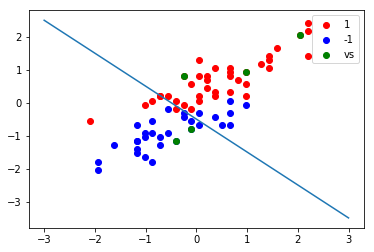

In [10]:
svm.plot(X_train, y_train)

Sprint2で作成したシンプルデータセット1の分類

In [11]:
"""
シンプルデータセット1作成コード
"""

import numpy as np

np.random.seed(seed=0)
n_samples = 500
f0= [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X_sample1 = X[random_index]
y_sample1 = y[random_index]

In [12]:
# サンプルデータ１を使用した分類
svm.pred(X_sample1)
accuracy_score(y_sample1, svm.pred(X_sample1))

0.478

In [ ]:
svm.plot(X_sample1, y_sample1)

明らかにおかしい。が、パラメータ等変更してもかわらなかった。

### 【問題5】時間の計測

上記で実行済み

### 【問題6】ロジスティック回帰とSVM

ロジスティック回帰とSVMの本質的な違いは、  
・カーネルを入れ替えることで非線形の分類もできる  
　→カーネルを入れ替えるだけで、非線形の分類ができるってことはカーネルで説明変数を増やしてると思われる  
・ロジスティック回帰が分類のモデルに対して、SVMは分類も連続値も求められる。  
・ロジスティック回帰は確率から分類している。  